In diesem Jupyter Notebook werden die Trainingsdaten von für den Finetuning-Task Multi-Temporal-Crop-Classification des Prithvi-100M Modells analysiert.

In [5]:
import os
import rasterio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# from: https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification

# Make sure you have git-lfs installed (https://git-lfs.com)
# git lfs install
!git clone https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification

Cloning into 'multi-temporal-crop-classification'...
Filtering content:  50% (2/4)
Filtering content:  50% (2/4), 1.09 GiB | 12.20 MiB/s
Filtering content:  75% (3/4), 1.09 GiB | 12.20 MiB/s
Filtering content:  75% (3/4), 2.97 GiB | 5.04 MiB/s 
Filtering content: 100% (4/4), 2.97 GiB | 5.04 MiB/s
Filtering content: 100% (4/4), 2.97 GiB | 5.02 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	training_chips.tgz

See: `git lfs help smudge` for more details.


Die Daten sind ca. 11 GB gross.

In [1]:
# extract files
!tar -xvf multi-temporal-crop-classification/validation_chips.tgz --directory multi-temporal-crop-classification
!tar -xvf multi-temporal-crop-classification/training_chips.tgz --directory multi-temporal-crop-classification

x ._validation_chips
x validation_chips/
x validation_chips/._chip_143_480_merged.tif
x validation_chips/chip_143_480_merged.tif
x validation_chips/._chip_126_446.mask.tif
x validation_chips/chip_126_446.mask.tif
x validation_chips/._chip_236_335.mask.tif
x validation_chips/chip_236_335.mask.tif
x validation_chips/._chip_077_612_merged.tif
x validation_chips/chip_077_612_merged.tif
x validation_chips/._chip_194_468_merged.tif
x validation_chips/chip_194_468_merged.tif
x validation_chips/._chip_281_251_merged.tif
x validation_chips/chip_281_251_merged.tif
x validation_chips/._chip_150_497.mask.tif
x validation_chips/chip_150_497.mask.tif
x validation_chips/._chip_209_433_merged.tif
x validation_chips/chip_209_433_merged.tif
x validation_chips/._chip_127_427.mask.tif
x validation_chips/chip_127_427.mask.tif
x validation_chips/._chip_170_402_merged.tif
x validation_chips/chip_170_402_merged.tif
x validation_chips/._chip_146_469_merged.tif
x validation_chips/chip_146_469_merged.tif
x valid

In [3]:


print("Number of files in training_chips: ", len(os.listdir('multi-temporal-crop-classification/training_chips')))
print("Number of files in validation_chips: ", len(os.listdir('multi-temporal-crop-classification/validation_chips')))

Number of files in training_chips:  12334
Number of files in validation_chips:  3084


Der Datensatz besteht aus einem trainings- und einem validierungsset. Die Trainingsdaten bestehen aus 12334 Bildern und die Validierungsdaten aus 3084 Bildern.

Hier untersuchen wir ein Bild genauer.

int16
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 224, 'height': 224, 'count': 18, 'crs': CRS.from_epsg(5070), 'transform': Affine(30.0, 0.0, 1319745.0,
       0.0, -30.0, 686205.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
(18, 224, 224)


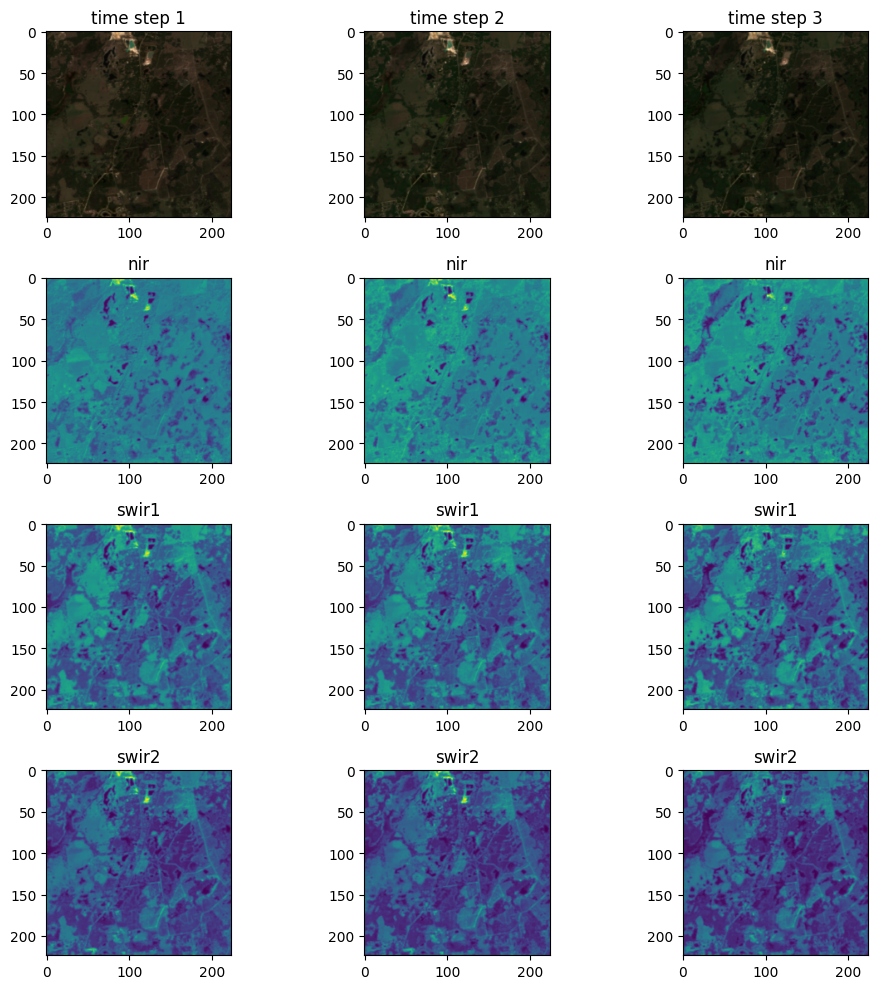

In [6]:
with rasterio.open('multi-temporal-crop-classification/training_chips/chip_370_547_merged.tif') as src:
    data = src.read()
    print(data.dtype) # int16
    print(src.profile) # metadata
    print(data.shape) # (18, 224, 224)

    fig, axs = plt.subplots(4, 3, figsize=(10, 10))
    for i in range(3):
        img_data = np.stack([data[i*6+2], data[i*6+1], data[i*6+0]], axis=-1)

        axs[0, i].imshow(img_data/np.max(img_data))
        axs[0, i].set_title(f'time step {i+1}')
        axs[1, i].imshow(data[i*6+3])
        axs[1, i].set_title('nir')
        axs[2, i].imshow(data[i*6+4])
        axs[2, i].set_title('swir1')
        axs[3, i].imshow(data[i*6+5])
        axs[3, i].set_title('swir2')

    plt.tight_layout()
    plt.show()

Das Bild wird als int16 gespeichert und hat die Form von 18x224x224 (bei einer Patch grösse von 1x16x16 gibt es 18x14x14 (3'528) Patches/Tokens).

Wobei ein Chip aus drei Timesteps mit jeweils 6 Channels besteht:
- Timestep 1 (bands 1-6)
- Timestep 2 (bands 7-12)
- Timestep 3 (bands 13-18)

Die Bänder/Channels sind wie folgt:
- 0: Blue
- 1: Green
- 2: Red
- 3: Narrow NIR
- 4: SWIR1
- 5: SWIR2


Die Metadaten sind:
```
{
    "driver": "GTiff", // Specifies the format driver used to interpret the data.
    "dtype": "int16", // Specifies the data type of the raster values.
    "nodata": -9999.0, // Indicates the value used to represent pixels with no data.
    "width": 224, // Denotes the width of the raster in terms of pixels.
    "height": 224, // Denotes the height of the raster in terms of pixels.
    "count": 18, // Specifies the number of bands in the raster.
    "crs": {
        "init": "epsg:5070" // CRS stands for Coordinate Reference System. The EPSG code 5070 refers to a specific CRS, which in this case is likely NAD83 / Conus Albers, a commonly used projection for environmental and land management data in the contiguous United States. `from_epsg(5070)` indicates that this EPSG code was used to define the CRS.
    },
    "transform": [30.0, 0.0, 1319745.0, 0.0, -30.0, 686205.0], // This affine transformation matrix is used to map pixel coordinates in the raster dataset to spatial coordinates in its coordinate reference system. The parameters can be interpreted as follows:
     // X-scale (30.0): Size of each pixel in the X-direction in CRS units.
     // Rotation terms (0.0, 0.0): These values are typically 0 for north-up images.
     // X-translation (1319745.0): The X coordinate of the upper left corner of the upper left pixel.
     // Y-scale (-30.0): Size of each pixel in the Y-direction in CRS units, negative because pixel row values increase from top to bottom.
     // Y-translation (686205.0): The Y coordinate of the upper left corner of the upper left pixel.

    "blockysize": 1, // This indicates the number of rows in each block of the image. A value of 1 suggests that each row is stored as a separate block, which can affect read/write performance depending on how the data is accessed.
    "tiled": false, // This indicates that the image is not stored in a tiled format. Tiling can affect how efficiently data can be read from the file, depending on the access pattern.
    "interleave": "pixel" // This describes how the band data is stored in the raster file. 'Pixel' interleave means that the data for each pixel across all bands is stored together. This is contrasted with 'band' interleave where all data for one band is stored together before moving to the next band. Pixel interleave is advantageous for workflows that require reading all bands for a pixel simultaneously (e.g., RGB visualization).
}
```

(1, 224, 224)
1 13


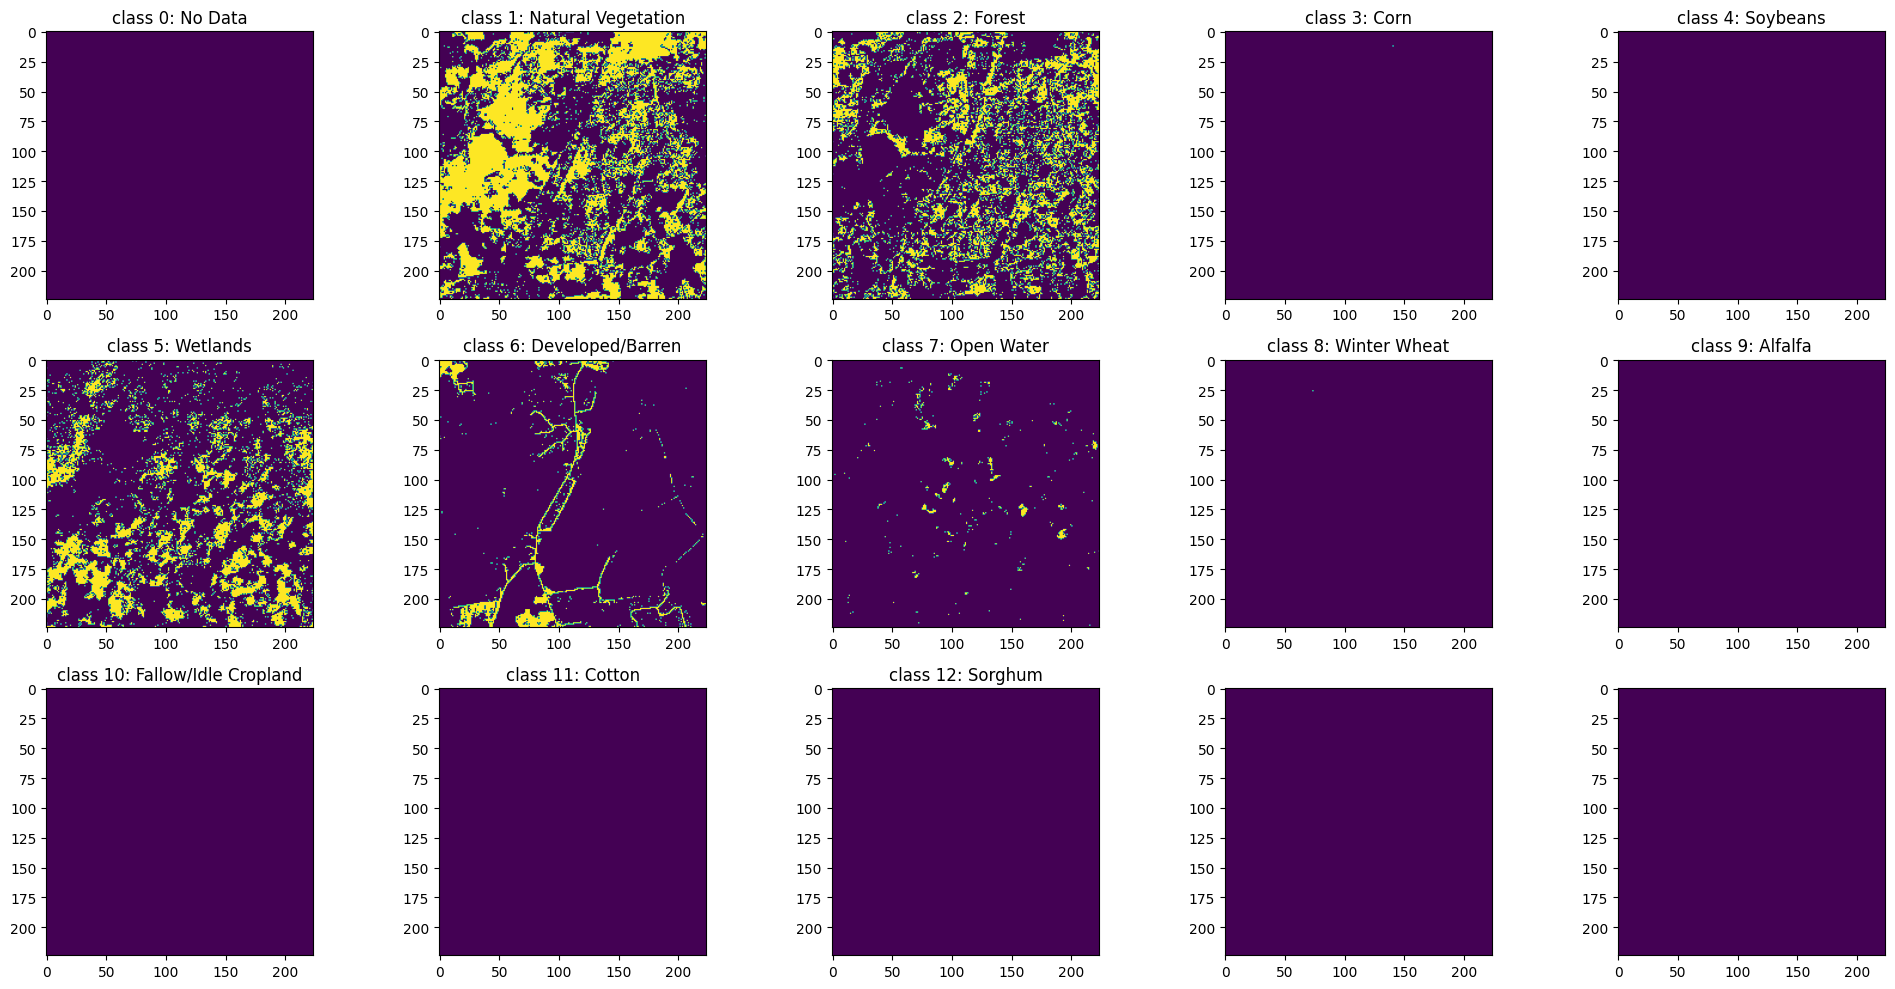

In [64]:
with rasterio.open('multi-temporal-crop-classification/training_chips/chip_370_547.mask.tif') as src:
    mask = src.read()
    print(mask.shape) # (1, 224, 224)
    print(np.min(mask), np.max(mask)) # 1 13 => the mask has 13 classes
    
    classes = [
        "No Data",
        "Natural Vegetation",
        "Forest",
        "Corn",
        "Soybeans",
        "Wetlands",
        "Developed/Barren",
        "Open Water",
        "Winter Wheat",
        "Alfalfa",
        "Fallow/Idle Cropland",
        "Cotton",
        "Sorghum",
        "Other",
    ]

    fig, axs = plt.subplots(3, 5, figsize=(20, 10))
    for i in range(13):
        axs[i//5, i%5].imshow(mask[0] == i)
        axs[i//5, i%5].set_title(f'class {i}: {classes[i]}')

    axs[2, 4].imshow(np.ones_like(mask[0]))
    axs[2, 3].imshow(np.ones_like(mask[0]))
    plt.tight_layout()
    plt.show()

Hier kann man gut die Klassen in der Maske sehen. Es gibt in diesem Bild einige Klassen, die gar nicht vorkommen und andere machen den Grossteil aus.